edited by jerry

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

In [18]:
transform = transforms.ToTensor()

# load data to train
trainset = torchvision.datasets.MNIST(
    root='./data/train',
    train=True,
    download=True,
    transform=transform
)

# load data to test
testset = torchvision.datasets.MNIST(
    root = './data/test',
    train = False,
    download = True,
    transform = transform
)

60000
torch.Size([1, 28, 28]) 5


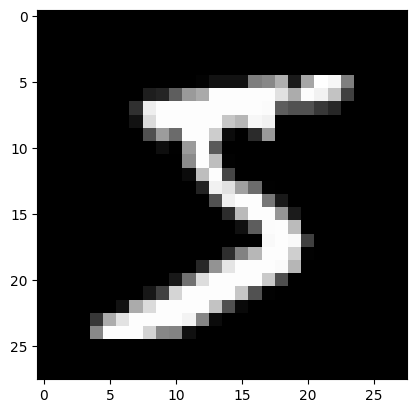

In [19]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [20]:
batch_size = 254

# dataloader for trainset
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# dataloader for testset
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [21]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([254, 1, 28, 28]) torch.Size([254])


1. Ensure Input Data is Float: In the Model class, you are flattening the input tensor x before passing it to the first layer. Make sure this tensor is of type float32. If it's not, convert it explicitly using .type(torch.float32) before flattening.

2. Output Dimension: The output dimension of the final layer (self.layer3) has been changed from 1 to 10 to match the number of classes in the MNIST dataset. This will ensure that the model outputs a probability distribution over the 10 possible digits.

3. Activation Function: The ReLU activation function has been removed from the final layer. This is because nn.CrossEntropyLoss expects raw, unnormalized scores (logits) as input. Removing the activation function allows the model to output these scores directly.

In [22]:
from torch import nn

# CNN model would be better
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # change output dimension to 10 for MNIST (0-9 digits)

    self.act = nn.ReLU()

  def forward(self, x):
    x = x.type(torch.float32) # ensure input data as float32
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # remove activation function from the final layer

    return x


model = Model(28 * 28 * 1, 1024)

In [23]:
import os

os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [24]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr) # adam would be better

In [25]:
# # Example of target with class indices
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input, target)
# output.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

define loss function

In [26]:
loss_fn = nn.CrossEntropyLoss() # for classification

train and test

In [27]:
n_epochs = 100
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.

  train_cnt = 0
  train_acc = 0
  test_cnt = 0
  test_acc = 0

  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)

    preds = torch.argmax(preds, dim=1)

    train_cnt += labels.shape[0]
    train_acc += (preds == labels).sum().item()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  train_accs.append(train_acc / train_cnt)

  for data in testloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)

    preds = torch.argmax(preds, dim=1)

    test_cnt += labels.shape[0]
    test_acc += (preds == labels).sum().item()

    loss.backward()
  test_accs.append(test_acc / test_cnt)



  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 544.8245174884796
Epoch   1 | Loss: 540.9683525562286
Epoch   2 | Loss: 537.033285856247
Epoch   3 | Loss: 532.9110996723175
Epoch   4 | Loss: 528.4366400241852
Epoch   5 | Loss: 523.4973964691162
Epoch   6 | Loss: 517.9189817905426
Epoch   7 | Loss: 511.62374806404114
Epoch   8 | Loss: 504.35138726234436
Epoch   9 | Loss: 496.0751705169678
Epoch  10 | Loss: 486.52471923828125
Epoch  11 | Loss: 475.53189492225647
Epoch  12 | Loss: 462.90623819828033
Epoch  13 | Loss: 448.6051000356674
Epoch  14 | Loss: 432.55446994304657
Epoch  15 | Loss: 414.8320540189743
Epoch  16 | Loss: 395.70431089401245
Epoch  17 | Loss: 375.3768398761749
Epoch  18 | Loss: 354.65174305438995
Epoch  19 | Loss: 333.89632284641266
Epoch  20 | Loss: 313.74141442775726
Epoch  21 | Loss: 294.69354581832886
Epoch  22 | Loss: 276.84917664527893
Epoch  23 | Loss: 260.5806490778923
Epoch  24 | Loss: 245.94142282009125
Epoch  25 | Loss: 232.81982058286667
Epoch  26 | Loss: 221.08821165561676
Epoch  27 | Lo

model accuracy plot

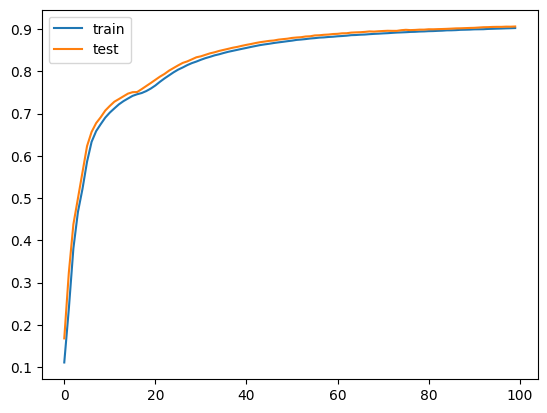

In [29]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accs, test_accs)

example of model accuracy

In [30]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[ 2.0261, -4.1638,  0.3662,  4.9929, -5.7753,  4.6806, -2.9742, -0.1115,
          1.3902, -0.4859]], device='cuda:0', grad_fn=<AddmmBackward0>)
5
